In [1]:
import pandas as pd

# File path
api_path = "/kaggle/input/crestdata-hackathon/dataset/API_Functions.csv"
dll_path = "/kaggle/input/crestdata-hackathon/dataset/DLLs_Imported.csv"
p_path = "/kaggle/input/crestdata-hackathon/dataset/portable_executable.csv"
test_path = "/kaggle/input/crestdata-hackathon/dataset/test.csv"

In [2]:
dlls_df = pd.read_csv(dll_path)
pe_df = pd.read_csv(p_path)
api_df = pd.read_csv(api_path)
test_df = pd.read_csv(test_path)

In [3]:
print(api_df.shape)
print(dlls_df.shape)
print(pe_df.shape)

(28017, 21920)
(28016, 631)
(28014, 144)


In [4]:
print(f"🔍 Unique SHA256 in DLLs: {dlls_df['SHA256'].nunique()}")
print(f"🔍 Unique SHA256 in PE Headers: {pe_df['SHA256'].nunique()}")
print(f"🔍 Unique SHA256 in API Calls: {api_df['SHA256'].nunique()}")

🔍 Unique SHA256 in DLLs: 28014
🔍 Unique SHA256 in PE Headers: 28014
🔍 Unique SHA256 in API Calls: 28014


In [5]:
dlls_sha = set(dlls_df["SHA256"])
pe_sha = set(pe_df["SHA256"])
api_sha = set(api_df["SHA256"])

# Find common SHA256 hashes across all datasets
common_sha256 = dlls_sha & pe_sha & api_sha

print(f"✅ Total Common SHA256 Across All Datasets: {len(common_sha256)}")

✅ Total Common SHA256 Across All Datasets: 28014


In [6]:
# Filter DLL dataset to only common SHA256
dlls_df = dlls_df[dlls_df["SHA256"].isin(common_sha256)]
pe_df = pe_df[pe_df["SHA256"].isin(common_sha256)]
api_df = api_df[api_df["SHA256"].isin(common_sha256)]

# ✅ Select exactly 2 records per class (only if they exist)
selected_sha256 = []
for class_label in range(7):  # Classes: 0 to 6
    class_samples = dlls_df[dlls_df["Type"] == class_label]["SHA256"].tolist()
    selected_sha256.extend(class_samples[:2000])  # Take first 100 available records

print(f"✅ Selected {len(selected_sha256)} SHA256 values for merging")

✅ Selected 13794 SHA256 values for merging


In [7]:
filtered_dlls_df = dlls_df[dlls_df["SHA256"].isin(selected_sha256)]
filtered_pe_df = pe_df[pe_df["SHA256"].isin(selected_sha256)]
filtered_api_df = api_df[api_df["SHA256"].isin(selected_sha256)]

# Merge based on SHA256
merged_train_df = filtered_dlls_df.merge(filtered_pe_df, on="SHA256", how="inner")
merged_train_df = merged_train_df.merge(filtered_api_df, on="SHA256", how="inner")

type_columns = [col for col in merged_train_df.columns if "Type" in col]
print(f"🔍 Found Type Columns Before Cleanup: {type_columns}")

# ✅ Check if 'Type_x' and 'Type_y' exist
if "Type_x" in merged_train_df.columns and "Type_y" in merged_train_df.columns:
    if (merged_train_df["Type_x"] == merged_train_df["Type_y"]).all():
        print("✅ 'Type_x' and 'Type_y' are identical. Dropping duplicates...")
        merged_train_df = merged_train_df.drop(columns=["Type_x", "Type_y"])
    else:
        print("⚠️ Warning: 'Type_x' and 'Type_y' have mismatched values. Keeping both for inspection!")

# Ensure 'Type' column remains and is numeric
if "Type" in merged_train_df.columns:
    merged_train_df["Type"] = pd.to_numeric(merged_train_df["Type"], errors="coerce")

# Final check on class distribution
print(f"✅ Merging Complete! Final Train Data Shape: {merged_train_df.shape}")
print("\n🔍 Class Distribution in Merged Dataset:")
print(merged_train_df["Type"].value_counts())

🔍 Found Type Columns Before Cleanup: ['Type_x', 'Type_y', 'Type']
✅ 'Type_x' and 'Type_y' are identical. Dropping duplicates...
✅ Merging Complete! Final Train Data Shape: (13796, 22691)

🔍 Class Distribution in Merged Dataset:
Type
5    2002
2    2000
1    2000
4    2000
3    2000
6    2000
0    1794
Name: count, dtype: int64


✅ Feature Scaling Complete! Data is now normalized.
[0]	validation_0-mlogloss:1.83265
[10]	validation_0-mlogloss:1.18796
[20]	validation_0-mlogloss:0.88550
[30]	validation_0-mlogloss:0.71203
[40]	validation_0-mlogloss:0.60561
[50]	validation_0-mlogloss:0.53932
[60]	validation_0-mlogloss:0.49734
[70]	validation_0-mlogloss:0.47009
[80]	validation_0-mlogloss:0.45221
[90]	validation_0-mlogloss:0.44015
[100]	validation_0-mlogloss:0.43273
[110]	validation_0-mlogloss:0.42683
[120]	validation_0-mlogloss:0.42347
[130]	validation_0-mlogloss:0.42102
[140]	validation_0-mlogloss:0.41952
[150]	validation_0-mlogloss:0.41897
[160]	validation_0-mlogloss:0.41838
[170]	validation_0-mlogloss:0.41866
[179]	validation_0-mlogloss:0.41856
✅ Model Accuracy: 0.8431

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       359
           1       0.94      0.94      0.94       400
           2       0.98      0.99      0.98       400
       

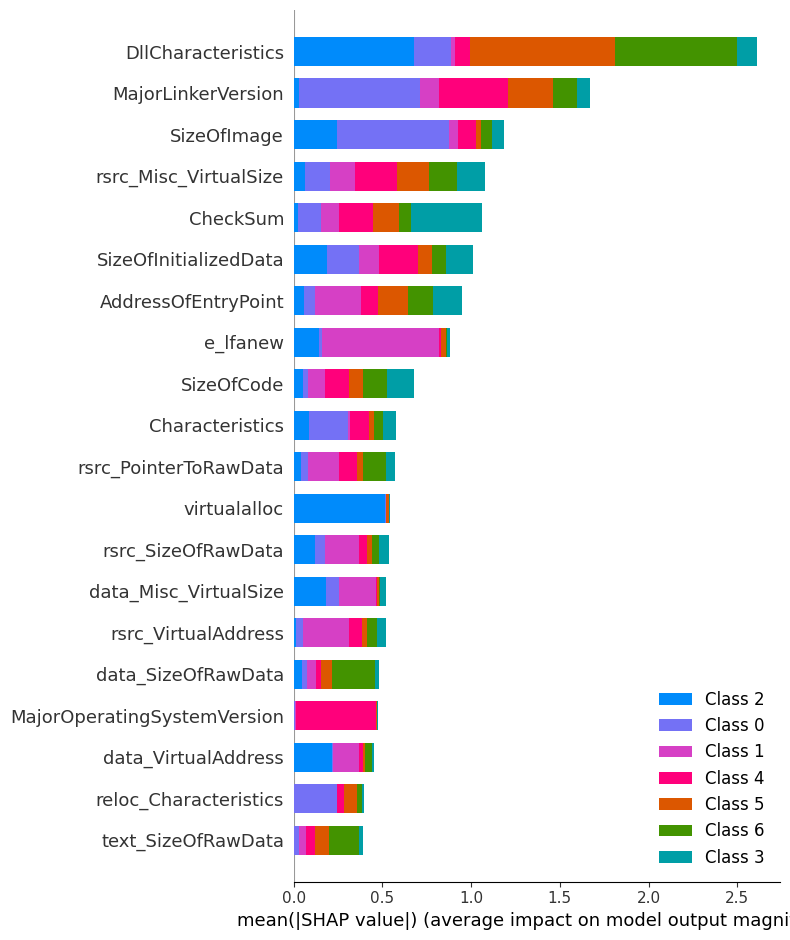

In [22]:
import shap
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = merged_train_df.drop(columns=['SHA256', 'Type', 'TimeDateStamp'])
y = merged_train_df['Type']

# ✅ Split into training and validation sets *before* scaling
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Initialize scaler and fit only on training data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)  # Fit + Transform on Train
# X_val_scaled = scaler.transform(X_val)  # Transform on Validation

# ✅ Convert back to DataFrame (optional, for easier debugging)
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

print("✅ Feature Scaling Complete! Data is now normalized.")

# ✅ Train XGBoost on GPU with optimized parameters
xgb_model = xgb.XGBClassifier(
    n_estimators=300,  # More trees for better learning
    max_depth=10,  # Increase depth to learn complex patterns
    learning_rate=0.05,  # Smaller step size for better accuracy
    subsample=0.8,  # Use 80% data to prevent overfitting
    colsample_bytree=0.8,  # Use 80% features per tree
    tree_method="hist", 
    device="cuda",
    eval_metric="mlogloss",
    early_stopping_rounds=20,  # Stop training if no improvement
    random_state=42
)

# ✅ Train the improved model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)

y_pred = xgb_model.predict(X_val)

# ✅ Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")  # Print accuracy

# ✅ Classification Report (Precision, Recall, F1-score)
print("\n🔍 Classification Report:")
print(classification_report(y_val, y_pred))

# ✅ Confusion Matrix
print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# ✅ Reduce sample size to avoid memory overload
explainer = shap.TreeExplainer(xgb_model)

# ✅ Reduce sample size to avoid memory overload
X_train_sample = X_train.sample(n=1000, random_state=42).to_numpy()  # Convert to NumPy

# ✅ Fix tree limit issue by using only trained trees
shap_values = explainer.shap_values(X_train_sample, tree_limit=xgb_model.best_iteration + 1, check_additivity=False)

# ✅ Save SHAP values for later use
np.save("shap_values.npy", shap_values)

# ✅ SHAP Summary Plot (Feature Importance)
shap.summary_plot(shap_values, X_train.iloc[:1000, :])  # Ensure same input format


In [23]:
import numpy as np
import pandas as pd

# ✅ Load SHAP values (Ensure correct path)
shap_values = np.load("/kaggle/working/shap_values.npy")

# ✅ Aggregate SHAP values across multiple classes (if multi-class classification)
if len(shap_values.shape) == 3:
    shap_values = np.abs(shap_values).mean(axis=0)  # Average across classes

# ✅ Compute Mean Absolute SHAP Values per Feature
shap_importance = np.abs(shap_values).mean(axis=0)  # Convert to 1D array

# ✅ Convert to DataFrame for better visualization
shap_df = pd.DataFrame({"Feature": X_train.columns, "SHAP_Value": shap_importance})

# ✅ Sort features by importance (highest SHAP values first)
shap_df = shap_df.sort_values(by="SHAP_Value", ascending=False).reset_index(drop=True)

# ✅ Set a SHAP Threshold to drop less important features
SHAP_THRESHOLD = 0.01  # Adjust this to filter out weak features

# ✅ Select only features above threshold
selected_features = shap_df[shap_df["SHAP_Value"] >= SHAP_THRESHOLD]["Feature"].tolist()

print(f"✅ Selected {len(selected_features)} Features (SHAP Threshold = {SHAP_THRESHOLD})")

# ✅ Filter dataset to include only selected features
X_train_filtered = X_train[selected_features]

✅ Selected 60 Features (SHAP Threshold = 0.01)


In [27]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import accuracy_score

# ✅ Define Bayesian Search Space
search_spaces = {
    "n_estimators": Integer(200, 400),
    "max_depth": Integer(8, 12),
    "learning_rate": Real(0.01, 0.1, "log-uniform"),
    "subsample": Real(0.7, 0.9),
    "colsample_bytree": Real(0.7, 0.9)
}

# ✅ Define base XGBoost model
xgb_base = xgb.XGBClassifier(
    tree_method="hist",
    device="cuda",
    eval_metric="mlogloss",
    random_state=42
)

# ✅ Run Bayesian Optimization with filtered features
opt = BayesSearchCV(
    xgb_base,
    search_spaces,
    n_iter=20,  # Runs only 20 iterations for efficiency
    cv=3,  # 3-Fold Cross Validation
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

# ✅ Fit Bayesian Search on full training data
opt.fit(X_train_filtered, y_train)

# ✅ Get the best parameters
best_params = opt.best_params_
print(f"✅ Best Params (After Feature Filtering): {best_params}")

# ✅ Train final model using the best parameters
xgb_model = xgb.XGBClassifier(
    **best_params,
    tree_method="hist",
    device="cuda",
    eval_metric="mlogloss",
    #early_stopping_rounds=20,
    random_state=42
)

# ✅ Train XGBoost with best params
xgb_model.fit(
    X_train_filtered, y_train,
    verbose=10
)

# ✅ Make predictions
y_pred = xgb_model.predict(X_train_filtered)

# ✅ Compute accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f"\n✅ Final Accuracy After SHAP Filtering: {accuracy:.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [24]:
required_columns = ["SHA256", "Type"] + selected_features  # Ensure SHA256 for merging

# ✅ Load only required columns from each dataset
dlls_df = pd.read_csv(dll_path, usecols=[col for col in required_columns if col in pd.read_csv(dll_path, nrows=1).columns])
pe_df = pd.read_csv(p_path, usecols=[col for col in required_columns if col in pd.read_csv(p_path, nrows=1).columns])
api_df = pd.read_csv(api_path, usecols=[col for col in required_columns if col in pd.read_csv(api_path, nrows=1).columns])
test_df = pd.read_csv(test_path, usecols=[col for col in required_columns if col in pd.read_csv(test_path, nrows=1).columns])

print(f"✅ Loaded DLLs Shape: {dlls_df.shape}")
print(f"✅ Loaded PE Headers Shape: {pe_df.shape}")
print(f"✅ Loaded API Calls Shape: {api_df.shape}")
print(f"✅ Loaded Test Shape: {test_df.shape}")

✅ Loaded DLLs Shape: (28016, 7)
✅ Loaded PE Headers Shape: (28014, 43)
✅ Loaded API Calls Shape: (28017, 16)
✅ Loaded Test Shape: (1480, 61)


In [25]:
dlls_sha = set(dlls_df["SHA256"])
pe_sha = set(pe_df["SHA256"])
api_sha = set(api_df["SHA256"])

# Find common SHA256 hashes across all datasets
common_sha256 = dlls_sha & pe_sha & api_sha

print(f"✅ Total Common SHA256 Across All Datasets: {len(common_sha256)}")

✅ Total Common SHA256 Across All Datasets: 28014


In [26]:
dlls_df = dlls_df[dlls_df["SHA256"].isin(common_sha256)]
pe_df = pe_df[pe_df["SHA256"].isin(common_sha256)]
api_df = api_df[api_df["SHA256"].isin(common_sha256)]

merged_train_df = dlls_df.merge(pe_df, on="SHA256", how="inner")
merged_train_df = merged_train_df.merge(api_df, on="SHA256", how="inner")

type_columns = [col for col in merged_train_df.columns if "Type" in col]
print(f"🔍 Found Type Columns Before Cleanup: {type_columns}")

# ✅ Check if 'Type_x' and 'Type_y' exist
if "Type_x" in merged_train_df.columns and "Type_y" in merged_train_df.columns:
    if (merged_train_df["Type_x"] == merged_train_df["Type_y"]).all():
        print("✅ 'Type_x' and 'Type_y' are identical. Dropping duplicates...")
        merged_train_df = merged_train_df.drop(columns=["Type_x", "Type_y"])
    else:
        print("⚠️ Warning: 'Type_x' and 'Type_y' have mismatched values. Keeping both for inspection!")

# Ensure 'Type' column remains and is numeric
if "Type" in merged_train_df.columns:
    merged_train_df["Type"] = pd.to_numeric(merged_train_df["Type"], errors="coerce")

# Final check on class distribution
print(f"✅ Merging Complete! Final Train Data Shape: {merged_train_df.shape}")
print(merged_train_df['Type'])

🔍 Found Type Columns Before Cleanup: ['Type_x', 'Type_y', 'Type']
✅ 'Type_x' and 'Type_y' are identical. Dropping duplicates...
✅ Merging Complete! Final Train Data Shape: (28019, 62)
0        0
1        0
2        0
3        0
4        0
        ..
28014    6
28015    6
28016    6
28017    6
28018    6
Name: Type, Length: 28019, dtype: int64


In [57]:
# ✅ Drop SHA256 (only needed for merging)
X_train_final = merged_train_df.drop(columns=["SHA256", "Type"])
#X_train_final = scaler.fit_transform(X_train_final)
y_train_final = merged_train_df["Type"]  # Keep labels

sha256_list = test_df["SHA256"]
X_test_final = test_df.drop(columns=["SHA256"]) # No 'Type' column in test set
features_used = X_test_final.columns.tolist()

print(f"✅ Final Train Shape: {X_train_final.shape}")
print(f"✅ Final Test Shape: {X_test_final.shape}")

✅ Final Train Shape: (28019, 60)
✅ Final Test Shape: (1480, 60)


In [56]:
from sklearn.model_selection import train_test_split

# ✅ Step 1: First, split into train (70%) & temp (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_final, y_train_final, test_size=0.3, random_state=42, stratify=y_train_final
)

#✅ Step 2: Split temp into validation (15%) & test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

# ✅ Print Shapes
print(f"✅ Training Set Shape: {X_train.shape}")
print(f"✅ Validation Set Shape: {X_val.shape}")
print(f"✅ Test Set Shape: {X_test.shape}")


✅ Training Set Shape: (19613, 60)
✅ Validation Set Shape: (4203, 60)
✅ Test Set Shape: (4203, 60)


In [55]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# # ✅ Define Individual Models
# base_models = [
#     ('xgb', xgb.XGBClassifier(
#         colsample_bytree=0.95,
#         learning_rate=0.0429,
#         max_depth=12,
#         n_estimators=400,
#         subsample=0.95,
#         tree_method="hist",
#         device="cuda",
#         eval_metric="mlogloss",
#         random_state=42
#     )),
#     ('rf', RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)),
#     ('lgb', lgb.LGBMClassifier(learning_rate=0.05, n_estimators=400, max_depth=12, random_state=42))
# ]

# # ✅ Define Meta-Learner (Logistic Regression with Increased Iterations)
# stacking_clf = StackingClassifier(
#     estimators=base_models,
#     final_estimator=LogisticRegression(solver='lbfgs', max_iter=2000),  # 🔥 Increased max_iter
# )

# # ✅ Train Stacking Model
# stacking_clf.fit(X_train_final, y_train_final)

# # ✅ Make Predictions
# # y_test_pred = stacking_clf.predict(X_test_scaled)

# # # ✅ Compute Accuracy
# # accuracy = accuracy_score(y_test, y_test_pred)
# # print(f"✅ Final Test Accuracy (Stacking Ensemble - Fixed): {accuracy:.4f}")

# # # ✅ Display Classification Report
# # print("\n🔍 Classification Report:")
# # print(classification_report(y_test, y_test_pred))

# # # ✅ Display Confusion Matrix
# # print("\n🔍 Confusion Matrix:")
# # print(confusion_matrix(y_test, y_test_pred))


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# ✅ Binarize the labels for multiclass Precision-Recall calculation
n_classes = len(set(y_train))  # Number of unique classes
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# ✅ Initialize Models
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.95,
    learning_rate=0.0429,
    max_depth=12,
    n_estimators=400,
    subsample=0.95,
    tree_method="hist",
    device="cuda",
    eval_metric="mlogloss",
    random_state=42
)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
lgb_model = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=400, max_depth=12, random_state=42)

# ✅ Define Meta-Learner (Stacking Classifier)
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('lgb', lgb_model)],
    final_estimator=LogisticRegression(solver='lbfgs', max_iter=2000)
)

# ✅ Train Models
models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "LightGBM": lgb_model,
    "Stacking Ensemble": stacking_clf
}

for name, model in models.items():
    print(f"🔹 Training {name}...")
    model.fit(X_train, y_train)

print("\n✅ All Models Trained Successfully!")


🔹 Training XGBoost...
🔹 Training Random Forest...
🔹 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5513
[LightGBM] [Info] Number of data points in the train set: 19613, number of used features: 60
[LightGBM] [Info] Start training from score -2.748261
[LightGBM] [Info] Start training from score -1.767531
[LightGBM] [Info] Start training from score -1.849317
[LightGBM] [Info] Start training from score -1.789264
[LightGBM] [Info] Start training from score -1.759205
[LightGBM] [Info] Start training from score -1.945146
[LightGBM] [Info] Start training from score -2.074407
🔹 Training Stacking Ensemble...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003794 seconds.
You can set `force_row_wise=true` to remove the overhead.
An

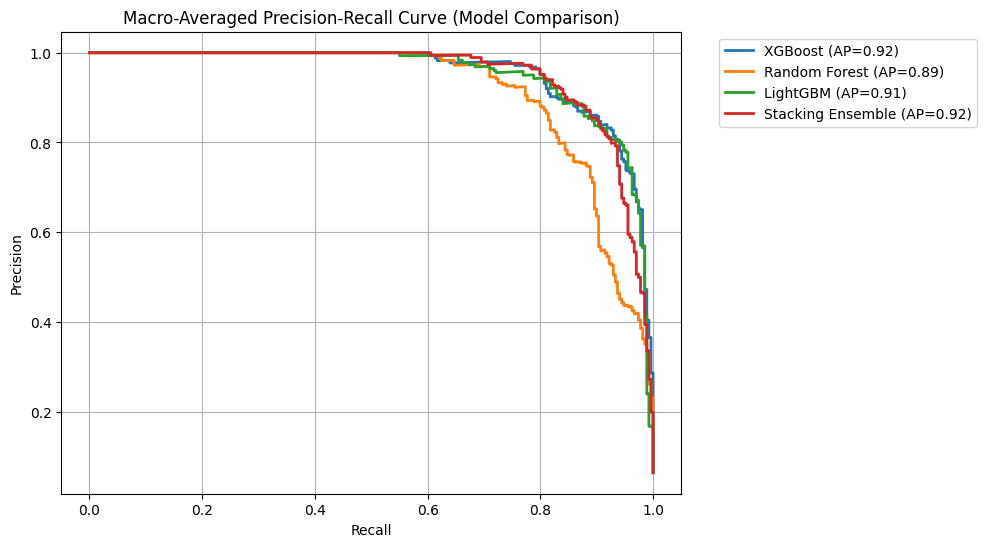

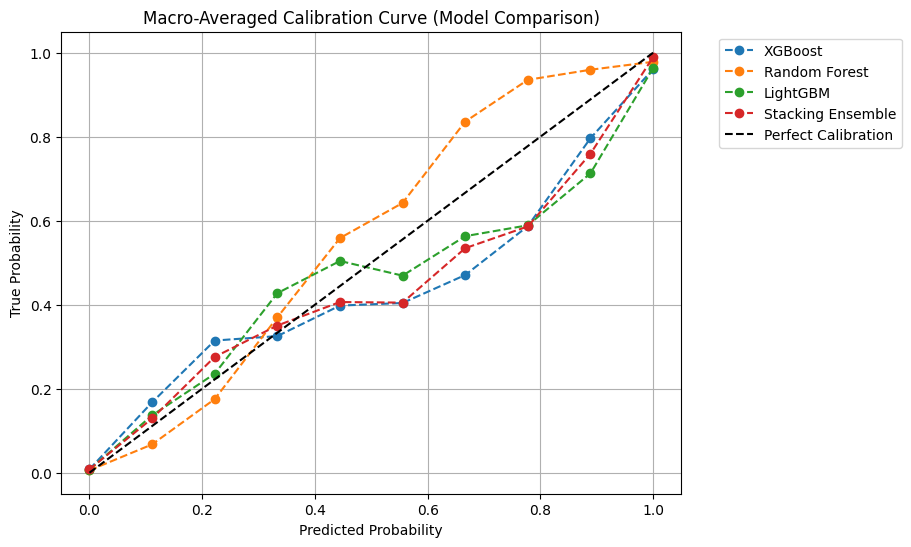

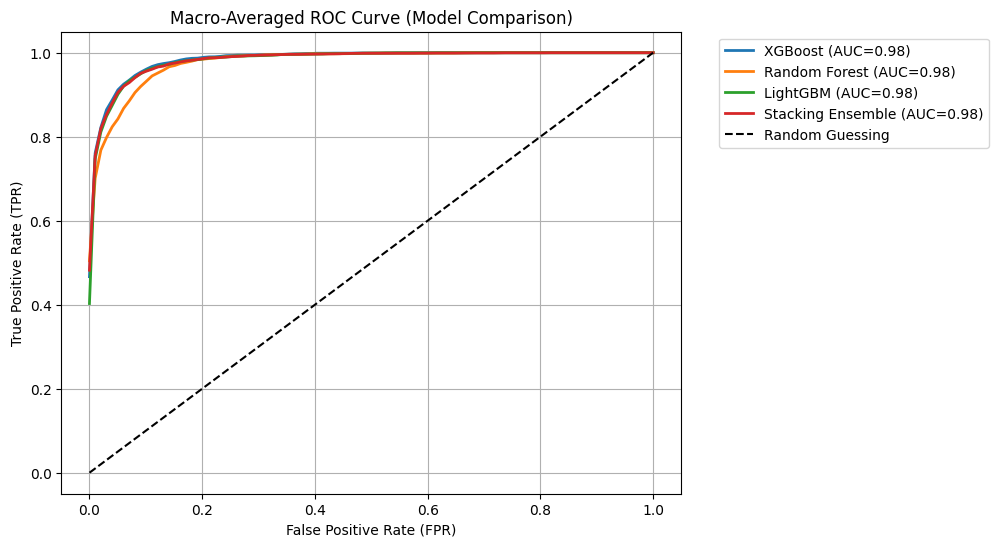

In [51]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)  # Get predicted probabilities

    # ✅ Compute macro-averaged precision-recall curve
    precision = dict()
    recall = dict()
    avg_precision = []

    for i in range(n_classes):
        p, r, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        precision[i] = p
        recall[i] = r
        avg_precision.append(average_precision_score(y_test_bin[:, i], y_proba[:, i]))

    # ✅ Compute macro-averaged AP Score
    avg_precision_macro = np.mean(avg_precision)

    # ✅ Plot Macro-Averaged PR Curve
    plt.plot(recall[0], precision[0], lw=2, label=f"{name} (AP={avg_precision_macro:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision-Recall Curve (Model Comparison)")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()

from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)  # Get predicted probabilities

    # ✅ Compute Calibration Curves for each class
    prob_true_all, prob_pred_all = [], []
    bin_count = 10  # Fixed bin count for consistency
    
    for i in range(n_classes):
        prob_true, prob_pred = calibration_curve(y_test_bin[:, i], y_proba[:, i], n_bins=bin_count)

        # ✅ Interpolate to ensure equal bin size
        prob_true_interp = np.interp(np.linspace(0, 1, bin_count), prob_pred, prob_true)
        prob_pred_interp = np.linspace(0, 1, bin_count)  # Force same bin locations

        prob_true_all.append(prob_true_interp)
        prob_pred_all.append(prob_pred_interp)

    # ✅ Compute Macro-Averaged Calibration
    avg_prob_true = np.mean(prob_true_all, axis=0)
    avg_prob_pred = np.mean(prob_pred_all, axis=0)

    # ✅ Plot Macro Calibration Curve
    plt.plot(avg_prob_pred, avg_prob_true, marker="o", linestyle="--", label=f"{name}")

# ✅ Plot Ideal Calibration Line
plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Perfect Calibration")

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Macro-Averaged Calibration Curve (Model Comparison)")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ✅ Binarize the labels for multiclass ROC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)  # Get predicted probabilities

    # ✅ Compute ROC Curve for each class
    fpr_all, tpr_all, roc_auc_all = [], [], []
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])  # Compute ROC per class
        roc_auc = auc(fpr, tpr)  # Compute AUC
        
        fpr_all.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))  # Interpolate
        tpr_all.append(np.linspace(0, 1, 100))
        roc_auc_all.append(roc_auc)

    # ✅ Compute Macro-Averaged ROC Curve
    avg_fpr = np.linspace(0, 1, 100)
    avg_tpr = np.mean(fpr_all, axis=0)
    avg_auc = np.mean(roc_auc_all)

    # ✅ Plot Macro ROC Curve
    plt.plot(avg_fpr, avg_tpr, lw=2, label=f"{name} (AUC={avg_auc:.2f})")

# ✅ Plot Random Chance Line
plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random Guessing")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Macro-Averaged ROC Curve (Model Comparison)")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()


✅ Final Test Accuracy: 0.8670

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       269
           1       0.96      0.92      0.94       718
           2       0.98      0.99      0.99       661
           3       0.87      0.83      0.85       703
           4       0.92      0.91      0.91       723
           5       0.74      0.75      0.75       601
           6       0.68      0.77      0.72       528

    accuracy                           0.87      4203
   macro avg       0.86      0.86      0.86      4203
weighted avg       0.87      0.87      0.87      4203


🔍 Confusion Matrix:
[[230   0   2  21   0   9   7]
 [  1 664   3   9  30   8   3]
 [  1   1 656   2   1   0   0]
 [ 14   5   4 582  12  41  45]
 [  6  19   1  19 655  11  12]
 [  6   0   2  16   6 451 120]
 [  1   1   0  23   8  89 406]]


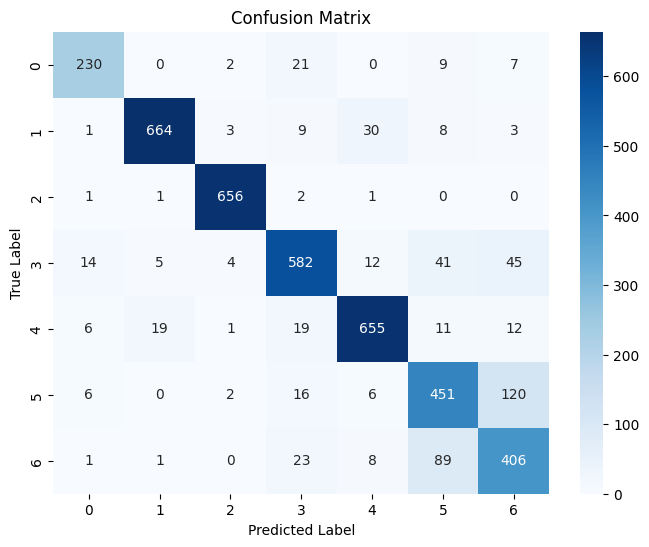

In [52]:
# import seaborn as sns
# xgb_model_final = xgb.XGBClassifier(
#     colsample_bytree=0.95,
#     learning_rate=0.0429,
#     max_depth=12,
#     n_estimators=400,
#     subsample=0.95,
#     tree_method="hist",
#     device="cuda",
#     eval_metric="mlogloss",  # ✅ Define metric here
#     early_stopping_rounds=20,  # ✅ Stop when validation loss stops improving
#     random_state=42
# )

# # ✅ Train the model
# xgb_model_final.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_val, y_val)],  # ✅ Use validation set
#     verbose=True
# )

# ✅ Retrieve evaluation results AFTER training
# evals_result = xgb_model.evals_result()

# ✅ Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

# ✅ Compute Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Final Test Accuracy: {accuracy:.4f}")

# ✅ Classification Report
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🔍 Confusion Matrix:")
print(cm)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [53]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss, precision_recall_curve
# from sklearn.calibration import calibration_curve

# fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
# plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC-AUC Curve")
# plt.legend(loc="lower right")
# plt.show()

# # ✅ Precision-Recall (PR) Curve
# num_classes = len(np.unique(y_test))

# # ✅ Plot PR Curve for Each Class
# plt.figure(figsize=(8,6))
# for i in range(num_classes):
#     precision, recall, _ = precision_recall_curve((y_test == i).astype(int), y_pred_proba[:, i])
#     plt.plot(recall, precision, lw=2, label=f'Class {i}')

# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve (Multiclass)")
# plt.legend()
# plt.show()

# class_labels = np.unique(y_test)

# # ✅ Compute Log Loss for Each Step
# log_losses = []
# for i in range(1, len(y_pred_proba) + 1):
#     log_losses.append(log_loss(y_test[:i], y_pred_proba[:i], labels=class_labels))  # ✅ Explicitly set labels

# # ✅ Plot Log Loss Curve
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(y_pred_proba) + 1), log_losses, color="red", lw=2)
# plt.xlabel("Number of Samples")
# plt.ylabel("Log Loss")
# plt.title("Log Loss Curve")
# plt.show()

# # ✅ Calibration Curve
# plt.figure(figsize=(8, 6))

# for class_label in range(y_pred_proba.shape[1]):  # Iterate over all classes
#     prob_true, prob_pred = calibration_curve(y_test == class_label, y_pred_proba[:, class_label], n_bins=10)
#     plt.plot(prob_pred, prob_true, marker="o", linestyle="--", label=f"Class {class_label}")

# # ✅ Plot Diagonal Reference Line
# plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Perfect Calibration")

# plt.xlabel("Predicted Probability")
# plt.ylabel("Fraction of Positives")
# plt.title("Calibration Curve (Multi-Class)")
# plt.legend()
# plt.show()

# # ✅ Training vs. Validation Loss
# plt.figure(figsize=(8, 6))
# plt.plot(evals_result["validation_0"]["mlogloss"], label="Training Loss", color="blue")
# plt.plot(evals_result["validation_1"]["mlogloss"], label="Validation Loss", color="red")
# plt.xlabel("Iterations")
# plt.ylabel("Log Loss")
# plt.title("Training vs. Validation Loss")
# plt.legend()
# plt.show()

In [59]:
# ✅ Print train and test column names
print("🔍 Training Columns Order:\n", list(X_train_final.columns))
print("\n🔍 Test Columns Order:\n", list(X_test_final.columns))

# ✅ Check which columns are mismatched
train_cols = set(X_train_final.columns)
test_cols = set(X_test_final.columns)

# ✅ Find missing features
missing_in_test = train_cols - test_cols
missing_in_train = test_cols - train_cols

print("\n🚨 Features in Train but missing in Test:", missing_in_test)
print("\n🚨 Features in Test but missing in Train:", missing_in_train)

🔍 Training Columns Order:
 ['kernel32.dll', 'user32.dll', 'gdi32.dll', 'mscoree.dll', 'msvbvm60.dll', 'e_lfanew', 'NumberOfSections', 'Characteristics', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'SizeOfImage', 'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics', 'NumberOfRvaAndSizes', 'text_Misc_VirtualSize', 'text_VirtualAddress', 'text_SizeOfRawData', 'text_PointerToRawData', 'data_Misc_VirtualSize', 'data_VirtualAddress', 'data_SizeOfRawData', 'data_PointerToRawData', 'rdata_Misc_VirtualSize', 'rdata_PointerToRawData', 'rsrc_Misc_VirtualSize', 'rsrc_VirtualAddress', 'rsrc_SizeOfRawData', 'rsrc_PointerToRawData', 'reloc_VirtualAddress', 'reloc_SizeOfRawData', 'reloc_PointerToRawData', 'reloc_Characteristics', 'pdata_PointerToRawData', 'getcurren

In [62]:
# predictions_df = pd.DataFrame(X_test_final, columns=features_used)  # Keep all features
# predictions_df.insert(0, "SHA256", sha256_list)  # Add SHA256 at the start

# #X_test_final = scaler.fit_transform(X_test_final)
# # ✅ Make Predictions
# y_test_predictions = xgb_model.predict(X_test_final)
# # y_test_predictions = stacking_clf.predict(X_test_final)

# # ✅ Convert Predictions to DataFrame (Reattach SHA256 & Features)

# predictions_df.insert(1, "Prediction", y_test_predictions)  # Add Predictions as second column

# # ✅ Save Predictions with Features to CSV
# predictions_df.to_csv("test_predictions.csv", index=False)

# print("✅ Final Predictions Saved as test_predictions.csv")
 
# # ✅ Inspect First 10 Predictions
# print(predictions_df.head(10))

✅ Final Predictions Saved as test_predictions.csv
                                              SHA256  Prediction  e_lfanew  \
0  c8deef6eb5744a1fed083051d7bf4a699c5880ee13f343...           0       128   
1  e9c61dda29f41d18c0e6abc6e8f80e483c86e425b8c18b...           0       128   
2  c1b0fc21a7f60a53af43fa4c0a986b38b8c053ce1fc2e0...           0       128   
3  fb0838b01028525cb8c52eb2315f46309cc13a4a78784f...           3       128   
4  e36ea87854cf4deb016e06c02457f2991613d50a8d9c78...           0       128   
5  c35c976b1b787bc1b29d72d074e7cdb2e943f496507cd3...           0       128   
6  dec09d6f6156b3785811d7ba3293a24371338c6d71f80a...           0       128   
7  c03550c783b27877194c29423b6cb5f7a801398f8e26c6...           3       128   
8  8ae2cbcd3c2ab0748d8df148e0009e1cb8bb47b59fb929...           0       128   
9  ca52a77522410cd004348f224089ac43242a6667a60b07...           0       128   

   NumberOfSections  Characteristics  MajorLinkerVersion  MinorLinkerVersion  \
0          

In [96]:
import lime
import lime.lime_tabular
import numpy as np

# ✅ Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_final,  # Use training data
    feature_names=features_used,  # Feature names
    class_names=[str(cls) for cls in np.unique(y_train_final)],  # Class labels
    mode="classification"
)

# ✅ Select a test instance (Example: First sample)
test_instance = X_test_final[0].reshape(1, -1)  # Reshape for model

# ✅ Explain the prediction
exp = explainer.explain_instance(
    test_instance.flatten(),  # Flatten input
    # stacking_clf.predict_proba,# Use model's probability output
    xgb_model_final.predict_proba,
    num_features=10  # Show top 10 important features
)

# ✅ Display the explanation
exp.show_in_notebook()

In [97]:
# ✅ Save LIME visualization as an image
exp.save_to_file('lime_explanation.html')

In [52]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import RandomForestClassifier
# import lightgbm as lgb

# # ✅ Define Individual Models
# xgb_model = xgb.XGBClassifier(
#     colsample_bytree=0.95,
#     learning_rate=0.0429,
#     max_depth=12,
#     n_estimators=400,
#     subsample=0.95,
#     tree_method="hist",
#     device="cuda",
#     eval_metric="mlogloss",
#     random_state=42
# )

# rf_model = RandomForestClassifier(
#     n_estimators=300, max_depth=12, random_state=42, n_jobs=-1
# )

# lgb_model = lgb.LGBMClassifier(
#     learning_rate=0.05, n_estimators=400, max_depth=12, random_state=42
# )

# # ✅ Create Voting Classifier (Hard Voting)
# voting_clf = VotingClassifier(
#     estimators=[('xgb', xgb_model), ('rf', rf_model), ('lgb', lgb_model)],
#     voting='hard'  # Can be 'soft' if using probabilities
# )

# # ✅ Train Ensemble Model
# voting_clf.fit(X_train, y_train)

# # ✅ Make Predictions
# y_test_pred = voting_clf.predict(X_test)

# # ✅ Compute Accuracy
# accuracy = accuracy_score(y_test, y_test_pred)
# print(f"✅ Final Test Accuracy (Voting Ensemble): {accuracy:.4f}")

# # ✅ Display Classification Report
# print("\n🔍 Classification Report:")
# print(classification_report(y_test, y_test_pred))

# # ✅ Display Confusion Matrix
# print("\n🔍 Confusion Matrix:")
# print(confusion_matrix(y_test, y_test_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5513
[LightGBM] [Info] Number of data points in the train set: 19613, number of used features: 60
[LightGBM] [Info] Start training from score -2.748261
[LightGBM] [Info] Start training from score -1.767531
[LightGBM] [Info] Start training from score -1.849317
[LightGBM] [Info] Start training from score -1.789264
[LightGBM] [Info] Start training from score -1.759205
[LightGBM] [Info] Start training from score -1.945146
[LightGBM] [Info] Start training from score -2.074407
✅ Final Test Accuracy (Voting Ensemble): 0.8658

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       269
           1       0.96      0.93      0.94       718
           2       0.98      0.9

In [49]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # ✅ Predict on Unseen Test Data
# y_test_pred = xgb_model_final.predict(X_test)

# # ✅ Compute accuracy
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"✅ Final Test Accuracy: {test_accuracy:.4f}")

# # ✅ Display Classification Report
# print("\n🔍 Classification Report:")
# print(classification_report(y_test, y_test_pred))

# # ✅ Display Confusion Matrix
# print("\n🔍 Confusion Matrix:")
# print(confusion_matrix(y_test, y_test_pred))

✅ Final Test Accuracy: 0.8651

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       269
           1       0.96      0.93      0.95       718
           2       0.98      0.99      0.98       661
           3       0.87      0.82      0.85       703
           4       0.93      0.91      0.92       723
           5       0.74      0.73      0.73       601
           6       0.67      0.79      0.72       528

    accuracy                           0.87      4203
   macro avg       0.86      0.86      0.86      4203
weighted avg       0.87      0.87      0.87      4203


🔍 Confusion Matrix:
[[228   0   4  20   2   8   7]
 [  1 667   3   8  28   8   3]
 [  1   1 655   3   1   0   0]
 [ 15   5   4 576  10  44  49]
 [  5  19   1  22 655   9  12]
 [  7   0   2  13   5 439 135]
 [  1   1   0  17   6  87 416]]


✅ Validation Accuracy: 1.0000

🔍 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       957
           2       1.00      1.00      1.00       882
           3       1.00      1.00      1.00       936
           4       1.00      1.00      1.00       965
           5       1.00      1.00      1.00       801
           6       1.00      1.00      1.00       704

    accuracy                           1.00      5604
   macro avg       1.00      1.00      1.00      5604
weighted avg       1.00      1.00      1.00      5604


🔍 Confusion Matrix:
[[359   0   0   0   0   0   0]
 [  0 957   0   0   0   0   0]
 [  0   0 882   0   0   0   0]
 [  0   0   0 936   0   0   0]
 [  0   0   0   0 965   0   0]
 [  0   0   0   0   0 801   0]
 [  0   0   0   0   0   0 704]]


In [37]:
# # ✅ Train final XGBoost model with best parameters
# xgb_model_final = xgb.XGBClassifier(
#     colsample_bytree=0.7899,
#     learning_rate=0.0528,
#     max_depth=9,
#     n_estimators=252,
#     subsample=0.8834,
#     tree_method="hist",
#     device="cuda",
#     eval_metric="mlogloss",
#     random_state=42
# )

# # ✅ Train model on full dataset
# xgb_model_final.fit(X_train_final, y_train_final, verbose=10)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7899, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0528, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=252, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)